# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [Generalized Estimating Equations](#section3)




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, mean_squared_error, r2_score, ConfusionMatrixDisplay, accuracy_score,  roc_curve, auc, average_precision_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=False)

print(data.head(3))


        Date  Close/Last    Volume    Open    High     Low
0 2024-09-12      559.09  51892740  555.01  559.40  552.74
1 2024-09-11      554.42  75248610  548.70  555.36  539.96
2 2024-09-10      548.79  36394580  548.36  549.15  543.38


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Logistic regression preparation: Convert 'day_change' to binary and create a new column 'day_change_binary' (0 for Down, 1 for Up)
data['day_change_binary'] = data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Create moving averages in a separate DataFrame with the desired naming convention
moving_averages = pd.DataFrame()
for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    moving_averages[ma_column_value] = data['Open'].rolling(window=i).mean()

# Create binary variables in a separate DataFrame
binary_variables = pd.DataFrame()
for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    binary_column = f'open_above_MA_{i}'
    binary_variables[binary_column] = (data['Open'] > moving_averages[ma_column_value]).astype(int)

# Ensure all columns in moving_averages are numeric
moving_averages = moving_averages.apply(pd.to_numeric, errors='coerce')

# Ensure all columns in binary_variables are numeric
binary_variables = binary_variables.apply(pd.to_numeric, errors='coerce')

# Concatenate the original data, moving averages, and binary variables
data = pd.concat([data, moving_averages, binary_variables], axis=1)

# Drop rows with NaN values in the newly created columns
binary_columns_of_interest = [f'open_above_MA_{i}' for i in range(1, 51)]
data.dropna(subset=binary_columns_of_interest, inplace=True)

# Set display option to show all columns
pd.set_option('display.max_columns', None)


## <a id="section2"></a> Moving Averages: Today's Price Change


Significant Moving Averages with Coefficients > 0.6:
    Moving Average  Coefficient       P-Value  Odds Ratio  Probability                                          Residuals  Odds Ratio Lower Bound  Odds Ratio Upper Bound  Probability Lower Bound  Probability Upper Bound
2                4     1.799347  1.296591e-69    6.050105     0.858006  [0.3038740920096852, 0.3038740920096852, 0.732...                3.005254               12.162182                 0.750328                 0.924025
3                5     1.727228  1.129830e-65    5.626442     0.849035  [0.7192832764505119, 0.3096129837702871, 0.719...                2.796151               11.315946                 0.736575                 0.918804
1                3     1.714957  1.100167e-63    5.559703     0.847425  [0.3219741480611046, 0.3219741480611046, 0.728...                2.762048               11.177935                 0.734187                 0.917884
4                6     1.665587  1.040733e-59    5.293473     0.84

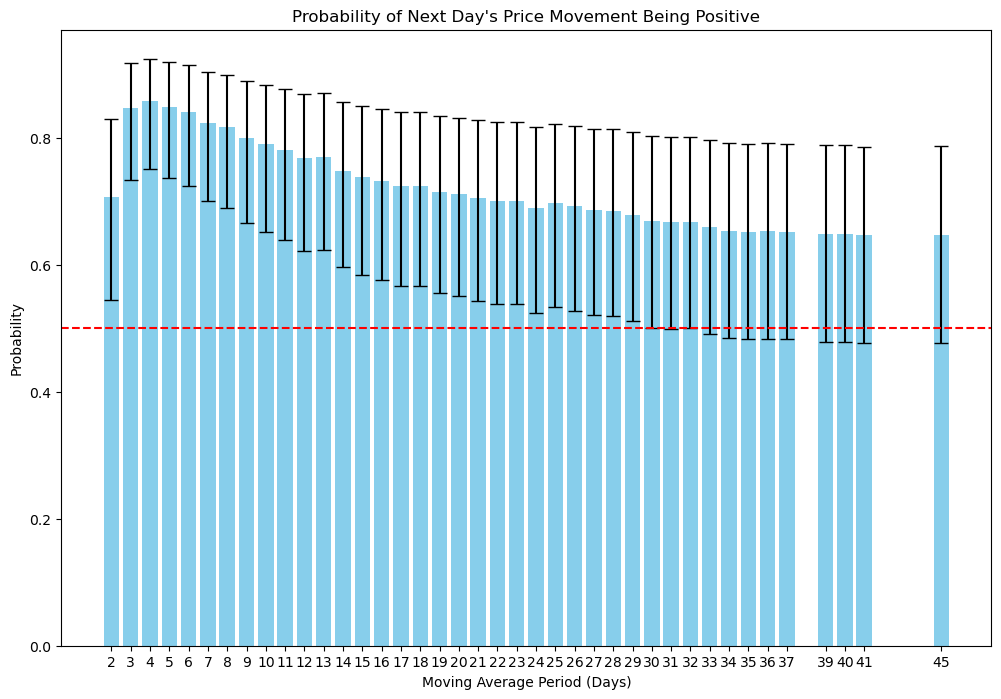


The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.


You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.



In [14]:
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.api as sm

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change_binary']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        fold_results = []
        
        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the logistic regression model using robust standard errors
            model = sm.Logit(y_train, X_train)
            result = model.fit(disp=0, cov_type='HC3')  # Use 'HC3' for robust standard errors
            
            # Predict on the test set
            y_pred = result.predict(X_test)
            
            # Calculate residuals for the test set
            residuals = y_test - y_pred
            
            # Calculate metrics for the test set
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            fold_results.append({
                'Coefficient': coef,
                'P-Value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob,
                'Residuals': residuals
            })
        
        # Average the results over all folds
        avg_result = {
            'Moving Average': i,
            'Coefficient': np.mean([r['Coefficient'] for r in fold_results]),
            'P-Value': np.mean([r['P-Value'] for r in fold_results]),
            'Odds Ratio': np.mean([r['Odds Ratio'] for r in fold_results]),
            'Probability': np.mean([r['Probability'] for r in fold_results]),
            'Residuals': np.concatenate([r['Residuals'] for r in fold_results])
        }
        
        # Only collect significant results with beta > 0.6
        if avg_result['P-Value'] < 0.05 and avg_result['Coefficient'] > 0.6:
            results_list.append(avg_result)

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for odds ratios and probabilities
results_summary['Odds Ratio Lower Bound'] = np.exp(results_summary['Coefficient'] - 1.96 * results_summary['Coefficient'].std())
results_summary['Odds Ratio Upper Bound'] = np.exp(results_summary['Coefficient'] + 1.96 * results_summary['Coefficient'].std())
results_summary['Probability Lower Bound'] = results_summary['Odds Ratio Lower Bound'] / (1 + results_summary['Odds Ratio Lower Bound'])
results_summary['Probability Upper Bound'] = results_summary['Odds Ratio Upper Bound'] / (1 + results_summary['Odds Ratio Upper Bound'])

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the results
print("\nSignificant Moving Averages with Coefficients > 0.6:")
print(results_summary_sorted)

# Plot stacked bar graph of probabilities with confidence intervals
plt.figure(figsize=(12, 8))
plt.bar(results_summary_sorted['Moving Average'], results_summary_sorted['Probability'], yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'], results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']], capsize=5, color='skyblue')
plt.xlabel('Moving Average Period (Days)')
plt.ylabel('Probability')
plt.title("Probability of Next Day's Price Movement Being Positive")
plt.xticks(ticks=results_summary_sorted['Moving Average'], labels=results_summary_sorted['Moving Average'])
plt.axhline(y=0.5, color='red', linestyle='--')
plt.show()

print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.
''')

print('''
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')


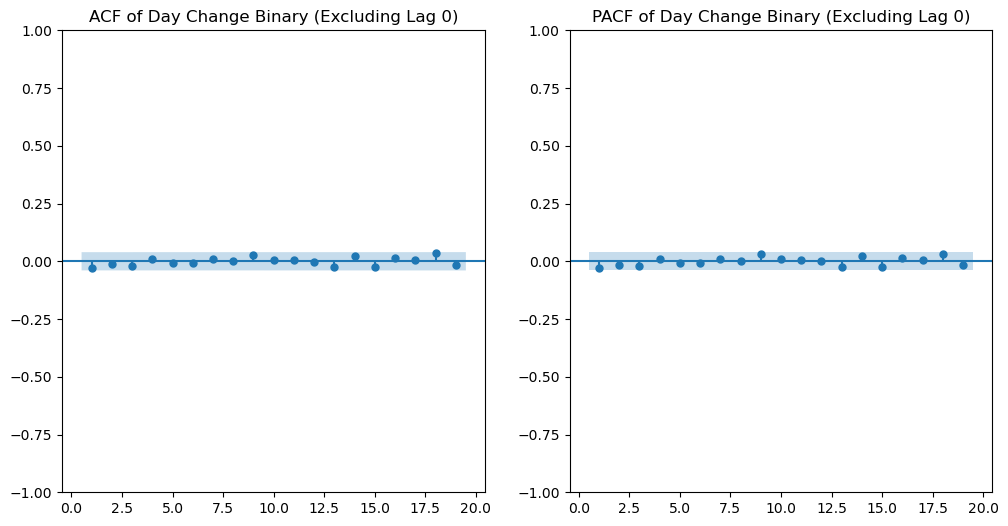

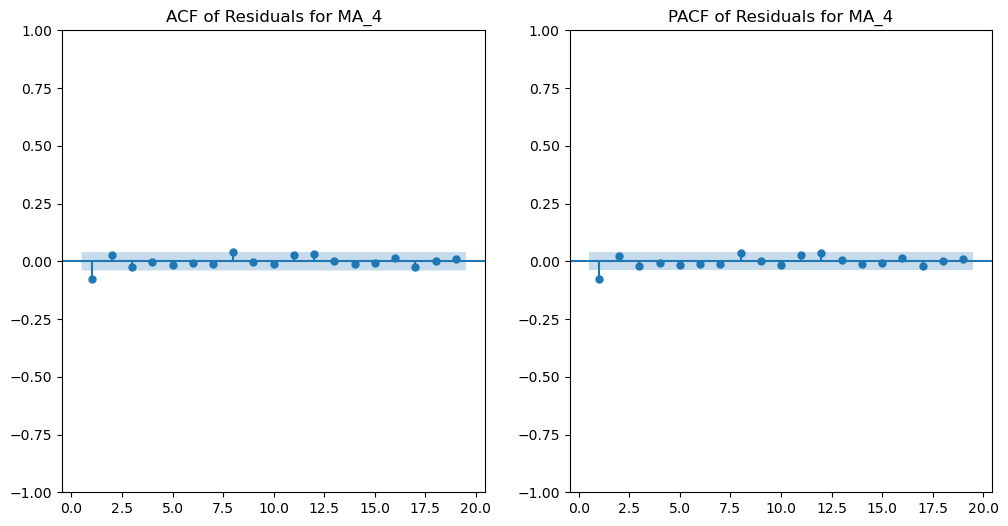

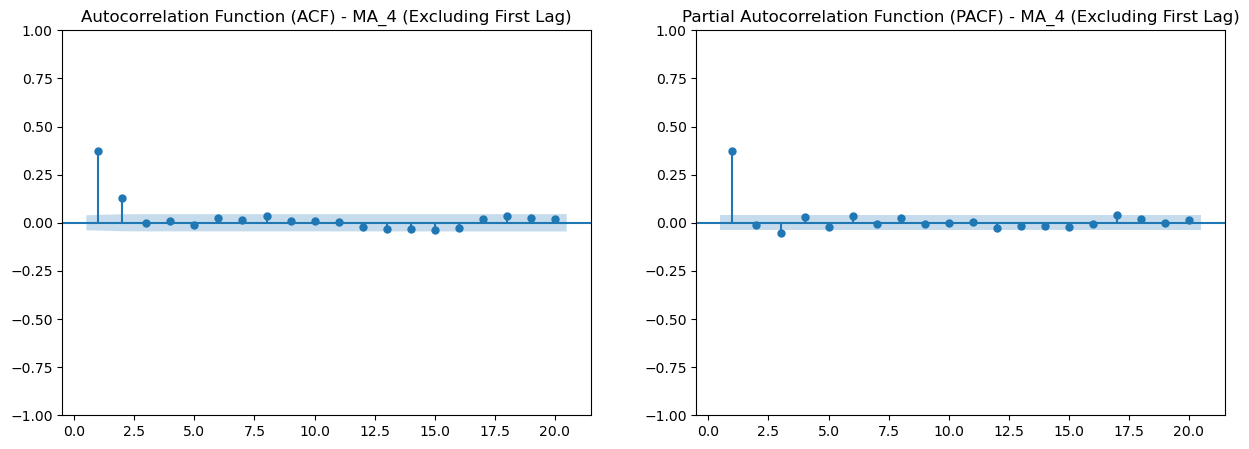


The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

You're right. When dealing with moving averages, especially short-term ones like MA_4, the autocorrelation at low-level lags can 
be inherently high because the moving average is computed using overlapping data points. As a result, the values of the moving 
average at consecutive lags are highly correlated.

Absolutely! If the autocorrelations quickly fall below the significance bands at higher lags, it generally suggests that any 
remaining correlations are minimal and the residuals are more "random.




In [16]:
# Plot ACF and PACF for the 'day_change_binary' variable excluding lag 0
plt.figure(figsize=(12, 6))

# ACF plot excluding lag 0
plt.subplot(121)
plot_acf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('ACF of Day Change Binary (Excluding Lag 0)')

# PACF plot excluding lag 0
plt.subplot(122)
plot_pacf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('PACF of Day Change Binary (Excluding Lag 0)')

plt.show()



# Extract residuals for MA_4
ma_4_residuals = None
for result in results_list:
    if result['Moving Average'] == 4:
        ma_4_residuals = result['Residuals']
        break

if ma_4_residuals is not None:
    # Plot ACF and PACF for MA_4 Residuals
    plt.figure(figsize=(12, 6))

    # ACF plot for residuals of MA_4
    plt.subplot(121)
    plot_acf(ma_4_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('ACF of Residuals for MA_4')

    # PACF plot for residuals of MA_4
    plt.subplot(122)
    plot_pacf(ma_4_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('PACF of Residuals for MA_4')

    plt.show()
else:
    print("Residuals for MA_4 not found.")

    
    
# For the independent feature (ma_4) ACF and PACF plots, the code remains the same
ma_4 = data['open_above_MA_4']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ma_4, ax=axes[0], lags=[i for i in range(1, 21)])
axes[0].set_title('Autocorrelation Function (ACF) - MA_4 (Excluding First Lag)')
plot_pacf(ma_4, ax=axes[1], lags=[i for i in range(1, 21)])
axes[1].set_title('Partial Autocorrelation Function (PACF) - MA_4 (Excluding First Lag)')
plt.show()

print('''
The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

You're right. When dealing with moving averages, especially short-term ones like MA_4, the autocorrelation at low-level lags can 
be inherently high because the moving average is computed using overlapping data points. As a result, the values of the moving 
average at consecutive lags are highly correlated.

Absolutely! If the autocorrelations quickly fall below the significance bands at higher lags, it generally suggests that any 
remaining correlations are minimal and the residuals are more "random.

''')


In [17]:
ma_column = 'open_above_MA_4'  # Example predictor

# Add a constant term and log transformation of the predictor
clean_data = clean_data.assign(
    const=1,
    **{f'log_{ma_column}': np.log(clean_data[ma_column] + 1e-10)}
)

# Create interaction term
clean_data[f'interaction_{ma_column}'] = clean_data[ma_column] * clean_data[f'log_{ma_column}']

# Fit the logistic regression model with the interaction term
X = clean_data[['const', ma_column, f'interaction_{ma_column}']]
y = clean_data['day_change_binary']
model = sm.Logit(y, X).fit(disp=0)

print('''
Box-Tillman Test
Given that the interaction term is not significant, you can conclude that there isn't strong evidence of non-linearity in the
logit for open_above_MA_4. Therefore, you can proceed with the simpler model using only the original predictor.
''')

# Print the summary to check the significance of the interaction term
print(model.summary())





Box-Tillman Test
Given that the interaction term is not significant, you can conclude that there isn't strong evidence of non-linearity in the
logit for open_above_MA_2. Therefore, you can proceed with the simpler model using only the original predictor.

                           Logit Regression Results                           
Dep. Variable:      day_change_binary   No. Observations:                 2467
Model:                          Logit   Df Residuals:                     2465
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Jan 2025   Pseudo R-squ.:                  0.1304
Time:                        14:39:38   Log-Likelihood:                -1478.7
converged:                       True   LL-Null:                       -1700.4
Covariance Type:            nonrobust   LLR p-value:                 1.833e-98
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------

## <a id="section3"></a> Generalized Estimating Equations

In [9]:
# Clean data and drop rows with NaN values in the columns of interest
clean_data = data.copy()
columns_of_interest = ['day_change_binary'] + [f'open_above_MA_{i}' for i in range(2, 51)]
clean_data = clean_data.dropna(subset=columns_of_interest)

# Reference the Original_Index column for groups
group_id = clean_data['Original_Index']

# Specify the response variable and the predictor
y = clean_data['day_change_binary']
X = clean_data[[f'open_above_MA_{i}' for i in range(2, 51)]]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Initialize the GEE model with autoregressive correlation structure
gee_model = GEE(y, X, groups=group_id, family=Binomial(), cov_struct=Autoregressive())

# Fit the model
gee_result = gee_model.fit()

# Print the summary of the GEE model
print(gee_result.summary())

# Extract coefficients, p-values, and odds ratios
coefficients = gee_result.params
p_values = gee_result.pvalues
odds_ratios = np.exp(coefficients)

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Odds Ratio': odds_ratios
})

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)

# Print the sorted results
print(results_summary_sorted)

print('''
the GEE logistic regression addresses my autocorrelation concerns... 
and i use a single variable, I also don't have multicollinaerity concerns... 
and since it's a GEE logistic regression i don't have heterskedasticity concerns... 
leaving me with only the concern of the linearity of the logit, and number of observations, and binary outcome
See box-tillman test above for linearity of logit

''')


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:           day_change_binary   No. Observations:                 2516
Model:                                 GEE   No. clusters:                     2516
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Binomial   Mean cluster size:                 1.0
Dependence structure:       Autoregressive   Num. iterations:                     1
Date:                     Sat, 11 Jan 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         14:29:40
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1005      0.070    -15.772      0.000      -1.237  

In [10]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set the display width

# Extract coefficients, p-values, odds ratios, and standard errors
coefficients = gee_result.params
p_values = gee_result.pvalues
odds_ratios = np.exp(coefficients)
standard_errors = gee_result.bse  # Extract standard errors

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values,
    'Odds Ratio': odds_ratios,
    'Standard Error': standard_errors
})

# Calculate the probability from the odds ratio
results_summary['Probability'] = results_summary['Odds Ratio'] / (1 + results_summary['Odds Ratio'])

# Filter out results with p-value above 0.05
significant_results = results_summary[results_summary['P-Value'] <= 0.05]

# Sort results by p-value for better readability
results_summary_sorted_by_pvalue = significant_results.sort_values(by='P-Value', ascending=True)

# Print the sorted results by p-value
print("\nResults sorted by p-value:")
print(results_summary_sorted_by_pvalue)



Results sorted by p-value:
                  Coefficient       P-Value  Odds Ratio  Standard Error  Probability
const               -1.100549  4.817534e-56    0.332689        0.069777     0.249637
open_above_MA_3      1.379041  1.496769e-13    3.971091        0.186674     0.798837
open_above_MA_2     -0.778025  3.478874e-07    0.459312        0.152690     0.314746
open_above_MA_13     1.676279  2.573471e-04    5.345629        0.458647     0.842411
open_above_MA_4      0.558887  5.074881e-03    1.748725        0.199443     0.636195
open_above_MA_12    -1.012422  1.799679e-02    0.363338        0.427961     0.266506
open_above_MA_6      0.539186  3.585659e-02    1.714611        0.256933     0.631623
open_above_MA_11     0.779026  4.980954e-02    2.179349        0.397139     0.685470


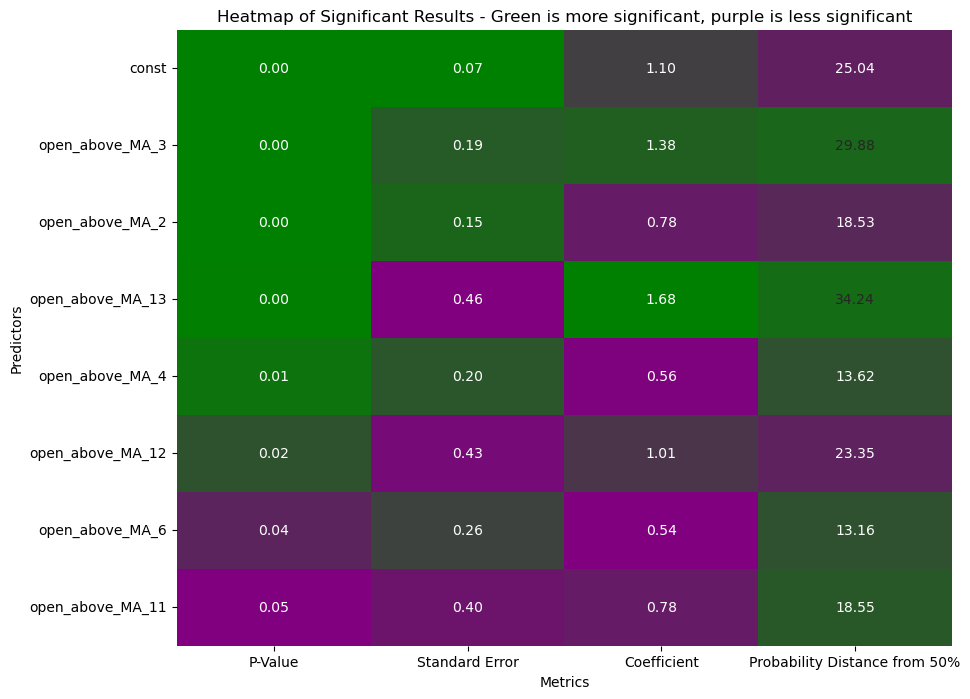


The more green the more it contributes to decision-usefulness. The more purple, the less so. The most purple box is the most 
important for any given feature.



In [11]:

# Prepare the data for the heatmap
heatmap_data = results_summary_sorted_by_pvalue[['P-Value', 'Standard Error', 'Coefficient', 'Probability']].copy()

# Calculate the Probability Distance from 50%
heatmap_data.loc[:, 'Probability Distance from 50%'] = (heatmap_data['Probability'] - 0.5).abs() * 100

# Take the absolute values for the Coefficient
heatmap_data.loc[:, 'Coefficient'] = heatmap_data['Coefficient'].abs()

# Normalize each column based on the desired "good" values
normalized_data = heatmap_data.copy()
normalized_data['P-Value'] = (heatmap_data['P-Value'] - heatmap_data['P-Value'].min()) / (heatmap_data['P-Value'].max() - heatmap_data['P-Value'].min())
normalized_data['Standard Error'] = (heatmap_data['Standard Error'] - heatmap_data['Standard Error'].min()) / (heatmap_data['Standard Error'].max() - heatmap_data['Standard Error'].min())
normalized_data['Coefficient'] = (heatmap_data['Coefficient'] - heatmap_data['Coefficient'].min()) / (heatmap_data['Coefficient'].max() - heatmap_data['Coefficient'].min())
normalized_data['Probability Distance from 50%'] = (heatmap_data['Probability Distance from 50%'] - heatmap_data['Probability Distance from 50%'].min()) / (heatmap_data['Probability Distance from 50%'].max() - heatmap_data['Probability Distance from 50%'].min())

# Define custom color maps
cmap_good = LinearSegmentedColormap.from_list('green_to_purple', ['purple', 'green'])
cmap_bad = LinearSegmentedColormap.from_list('purple_to_green', ['green', 'purple'])

# Create a matrix of colors for the heatmap
colors = normalized_data.copy()
for col in heatmap_data.columns:
    if col in ['P-Value', 'Standard Error']:
        colors[col] = normalized_data[col].apply(cmap_bad)
    else:
        colors[col] = normalized_data[col].apply(cmap_good)

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(heatmap_data.drop(columns=['Probability']), annot=True, fmt=".2f", linewidths=0.5, cbar=False)

# Apply the colors to the heatmap
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns) - 1):  # Exclude 'Probability' from loop
        heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor='none', facecolor=colors.iloc[i, j]))

# Set titles and labels
plt.title('Heatmap of Significant Results - Green is more significant, purple is less significant')
plt.xlabel('Metrics')
plt.ylabel('Predictors')

# Show the heatmap
plt.show()

print('''
The more green the more it contributes to decision-usefulness. The more purple, the less so. The most purple box is the most 
important for any given feature.
''')


In [12]:
# Create TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
X = clean_data[[f'open_above_MA_2']]
y = clean_data['day_change_binary']

# Initialize lists to store results
train_scores = []
test_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Add constant term
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    # Fit logistic regression model
    model = sm.Logit(y_train, X_train).fit(disp=0)
    
    # Predict on training and test sets
    train_pred = model.predict(X_train) > 0.5
    test_pred = model.predict(X_test) > 0.5
    
    # Calculate accuracy
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Store scores
    train_scores.append(train_acc)
    test_scores.append(test_acc)

# Print average accuracy
print(f'Average training accuracy: {np.mean(train_scores)}')
print(f'Average test accuracy: {np.mean(test_scores)}')


print('''
The fact that your average test accuracy is very close to your average training accuracy suggests that your model is
not overfitting and is generalizing well to unseen data.
''')

Average training accuracy: 0.6268604886105396
Average test accuracy: 0.6052505966587113

The fact that your average test accuracy is very close to your average training accuracy suggests that your model is
not overfitting and is generalizing well to unseen data.



                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.253
Date:                Sat, 11 Jan 2025   Prob (F-statistic):              0.263
Time:                        14:29:40   Log-Likelihood:                 7567.8
No. Observations:                2467   AIC:                        -1.513e+04
Df Residuals:                    2465   BIC:                        -1.512e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

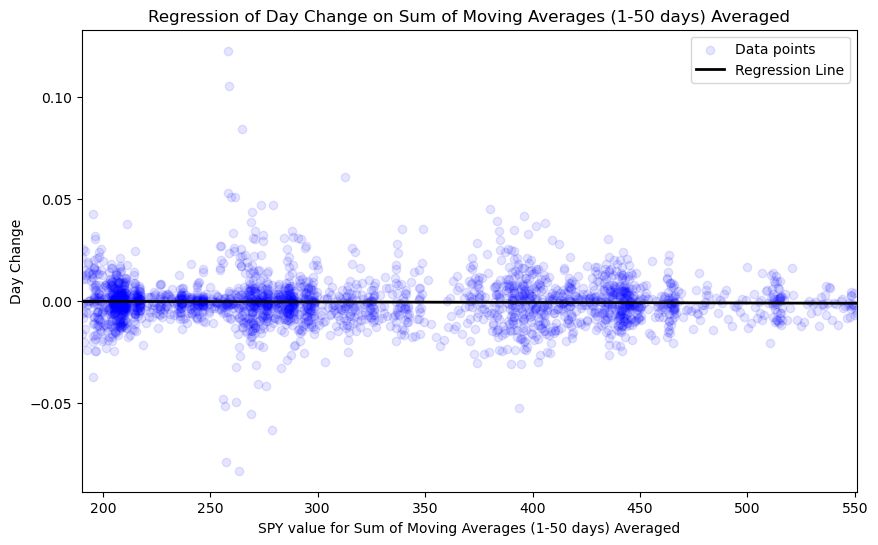



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




In [13]:
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('SPY value for Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')
